<a href="https://colab.research.google.com/github/YangWorking/Deep_learning/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

In [190]:
#################################
######## Hyperparameters ########
#################################

# Fixed
input_dim = 1
num_layers = 1
hidden_dim = 32
output_dim = 1
num_epochs = 1000
lr = 0.001
batch_size = 32
dropout_prob = 0.2
weight_decay = 0.0005
max_grad_norm = 1.0
patience_level = 50
chunk_size = 200

# Tuning

# lookback = 20
# lookback = 40
lookback = 60
# lookback = 80
# lookback = 120

In [191]:
#####################################
######## Data Pre-processing ########
#####################################

def load_and_preprocess_data(batch_size, lookback):
    # Loading stock data
    asx_200 = yf.Ticker('^AXJO')
    train_data = asx_200.history(start='2012-10-01', end='2022-10-01')
    test_data = asx_200.history(start='2022-10-01', end='2023-11-01')

    # Normalization / Feature Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data = train_data[['Close']]
    test_data = test_data[['Close']]
    train_data['Close'] = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
    test_data['Close'] = scaler.fit_transform(test_data['Close'].values.reshape(-1, 1))

    # train_data = train_data.diff()
    # test_data = test_data.diff()

    # Splitting train and valid sets
    length_data = len(train_data)
    train_ratio = 0.9
    train_size = int(length_data * train_ratio)
    valid_size = length_data - train_size

    # Convert to a numpy array
    train_data = train_data.to_numpy()
    test_data = test_data[['Close']].to_numpy()

    x_train = []
    y_train = []
    x_valid = []
    y_valid = []
    x_test = []
    y_test = []

    # Create all possible sequences of length lookback
    data = []
    for index in range(len(train_data) - lookback):
        data.append(train_data[index: index + lookback])

    train_data = np.array(data)
    # Split the data into training and test sets
    x_train = train_data[:train_size, :-1, :]
    y_train = train_data[:train_size, -1, :]
    x_valid = train_data[train_size:, :-1, :]
    y_valid = train_data[train_size:, -1, :]

    # Create all possible sequences of length lookback for the test data
    for index in range(len(test_data) - lookback):
        x_test.append(test_data[index: index + lookback - 1])
        y_test.append(test_data[index + lookback - 1])

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Transform them into tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_valid = torch.tensor(x_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    trainloader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size)
    validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=batch_size)
    testloader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

    return trainloader, validloader, testloader, x_test, y_test, scaler

trainloader, validloader, testloader, x_test, y_test, scaler = load_and_preprocess_data(batch_size, lookback)

In [192]:
######################
######## LSTM ########
######################

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers,
                            batch_first=True,
                            dropout=dropout_prob)

        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

#####################
######## GRU ########
#####################

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim,
                          hidden_dim,
                          num_layers,
                          batch_first=True,
                          dropout=dropout_prob)

        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

########################
######## BiLSTM ########
########################

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers,
                            batch_first=True,
                            dropout=dropout_prob,
                            bidirectional=True)  # Use bidirectional LSTM

        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # Multiply by 2 for bidirectional LSTM

        # Readout layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional LSTM

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()  # Multiply by 2 for bidirectional LSTM

        # Initialize cell state
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.bilstm(x, (h0.detach(), c0.detach()))  # Use bidirectional LSTM
        out = self.fc(out[:, -1, :])

        return out

In [193]:
#############################
######## train_model ########
#############################

def train_model(model, trainloader, optimizer, criterion):

    model.train()
    correct = 0
    total = 0
    current_train_loss = 0.0

    for x_batch, y_batch in trainloader:
        optimizer.zero_grad()

        # Truncated backpropagation
        # Split the input sequence into chunks
        chunked_x = x_batch.split(chunk_size, dim=1)
        chunked_y = y_batch.split(chunk_size, dim=1)

        for chunk_x, chunk_y in zip(chunked_x, chunked_y):
            train_y_pred = model(chunk_x)
            loss = criterion(train_y_pred, chunk_y)
            loss.backward()
            current_train_loss += loss.item()

        # train_y_pred = model(x_batch)
        # loss = criterion(train_y_pred, y_batch)
        # loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # current_train_loss += loss.item()

    train_loss = current_train_loss / len(trainloader)
    # train_accuracy = correct / total

    return train_loss

################################
######## evaluate_model ########
################################

def evaluate_model(model, validloader, criterion):
    model.eval()
    current_valid_loss = 0.0

    with torch.no_grad():
        for x_valid, y_valid in validloader:
            y_valid_pred = model(x_valid)
            loss = criterion(y_valid_pred, y_valid)
            current_valid_loss += loss.item()

    valid_loss = current_valid_loss / len(validloader)

    return valid_loss

############################
######## train_loop ########
############################

def train_loop(num_epochs, trainloader, validloader, model, optimizer, criterion, patience):
    best_valid_loss = float('inf')  # Initialize with a high value

    for epoch in range(num_epochs):
        train_loss = train_model(model, trainloader, optimizer, criterion)
        valid_loss = evaluate_model(model, validloader, criterion)

        # Monitoring
        if epoch % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch} Train_Loss: {train_loss:.5f} Valid_Loss: {valid_loss:.5f} Patient: {patience}")

        # Early stopping
        if valid_loss < best_valid_loss:
            patience = patience_level # reset patience
            best_valid_loss = valid_loss
        else:
            patience -= 1

        training_metrics.append({
            'epoch': epoch + 1,
            'loss': train_loss
        })

        valid_metrics.append({
            'epoch': epoch + 1,
            'loss': valid_loss
        })

        # Breaking the loop if patience reduces to 0
        if patience == 0:
            print(f'Early stopping after {epoch + 1} epochs without improvement in validation loss.')
            break

    return print("Finished Training")

In [194]:
# Models, Loss function, optimizer and lr_scheduler

# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# model = BiLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [195]:
training_metrics = []
valid_metrics = []
train_loop (num_epochs, trainloader, validloader, model, optimizer, criterion, patience_level)

Epoch 0 Train_Loss: 0.10034 Valid_Loss: 0.08468 Patient: 50
Epoch 10 Train_Loss: 0.00215 Valid_Loss: 0.00435 Patient: 50
Epoch 20 Train_Loss: 0.00174 Valid_Loss: 0.00355 Patient: 50
Epoch 30 Train_Loss: 0.00156 Valid_Loss: 0.00314 Patient: 50
Epoch 40 Train_Loss: 0.00144 Valid_Loss: 0.00293 Patient: 50
Epoch 50 Train_Loss: 0.00135 Valid_Loss: 0.00258 Patient: 50
Epoch 60 Train_Loss: 0.00139 Valid_Loss: 0.00244 Patient: 50
Epoch 70 Train_Loss: 0.00139 Valid_Loss: 0.00243 Patient: 50
Epoch 80 Train_Loss: 0.00139 Valid_Loss: 0.00243 Patient: 50
Epoch 90 Train_Loss: 0.00138 Valid_Loss: 0.00242 Patient: 50
Epoch 100 Train_Loss: 0.00137 Valid_Loss: 0.00241 Patient: 50
Epoch 110 Train_Loss: 0.00136 Valid_Loss: 0.00240 Patient: 50
Epoch 120 Train_Loss: 0.00135 Valid_Loss: 0.00239 Patient: 50
Epoch 130 Train_Loss: 0.00135 Valid_Loss: 0.00238 Patient: 50
Epoch 140 Train_Loss: 0.00134 Valid_Loss: 0.00237 Patient: 50
Epoch 150 Train_Loss: 0.00133 Valid_Loss: 0.00236 Patient: 50
Epoch 160 Train_Los

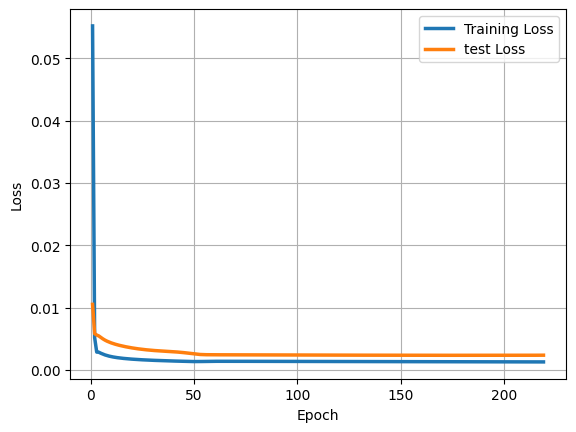

In [206]:
def plot_losses(training_metrics, valid_metrics):
    # Extract the training and validation losses from the metrics
    train_losses = [metric['loss'] for metric in training_metrics]
    valid_losses = [metric['loss'] for metric in valid_metrics]

    skip = 1

    # Create an array of epoch numbers for the x-axis
    epochs = range(skip, len(training_metrics))

    # Skip some loss values for both training and validation
    train_losses = train_losses[skip:]
    valid_losses = valid_losses[skip:]

    # Plot the training and validation loss curves
    plt.plot(epochs, train_losses, label='Training Loss', linewidth=2.5)
    plt.plot(epochs, valid_losses, label='test Loss', linewidth=2.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

plot_losses(training_metrics, valid_metrics)

In [201]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to calculate test metrics
def calculate_and_convert_metrics(model, dataloader, scaler):

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_data, y_data in dataloader:
            y_pred = model(x_data)
            predictions.append(y_pred)
            actuals.append(y_data)

    predictions = torch.cat(predictions, dim=0).numpy()
    actuals = torch.cat(actuals, dim=0).numpy()

    # Inverse scaling transformation
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # Calculate MAE, RMSE, and MAE on the original scale
    mse = mean_squared_error(actuals_original, predictions_original)
    rmse = math.sqrt(mean_squared_error(actuals_original, predictions_original))
    r2 = r2_score(actuals_original, predictions_original)

    return mse, rmse, r2

# Calculate and convert metrics for training, validation, and test datasets
train_mse, train_rmse, train_r2 = calculate_and_convert_metrics(model, trainloader, scaler)
test_mse, test_rmse, test_r2 = calculate_and_convert_metrics(model, testloader, scaler)

# Create a Pandas DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'MSE': [train_mse, test_mse],
    'RMSE': [train_rmse, test_rmse],
    'R2': [train_r2, test_r2]
})

# Set the 'Dataset' column as the index for the table
metrics_df.set_index('Dataset', inplace=True)

# Round the 'MSE' and 'RMSE' columns to two decimal places
metrics_df['MSE'] = metrics_df['MSE'].apply(lambda x: round(x, 3))
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: round(x, 3))
metrics_df['R2'] = metrics_df['R2'].apply(lambda x: round(x, 3))

# Print the metrics table
print(metrics_df)

               MSE    RMSE     R2
Dataset                          
Training   395.682  19.892  0.992
Test      3390.644  58.229  0.865


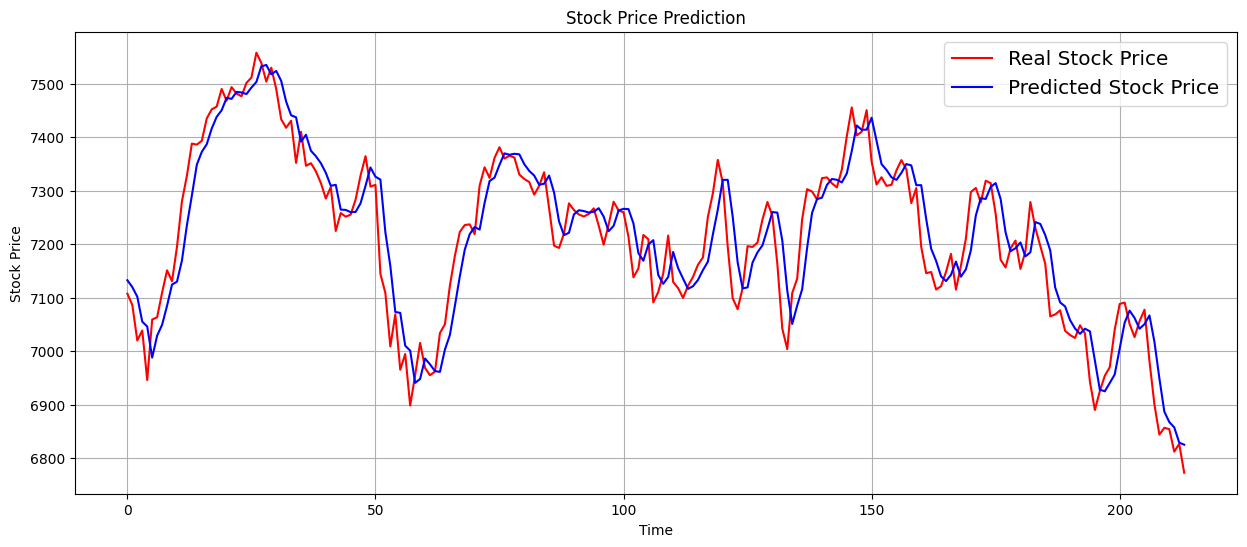

In [204]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_test_pred = model(x_test).detach().numpy()  # Convert the predicted tensor to a NumPy array

# Create a numerical index for the x-axis
index = np.arange(len(y_test))

# Inverse transform the scaled data to get the actual stock prices
y_test_actual = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(15, 6))
plt.plot(index, y_test_actual, color='red', label='Real Stock Price')
plt.plot(index, y_test_pred, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(fontsize='x-large')
plt.grid()
plt.show()